# Create Needle In A Haystack Visualization

Let's run through how to create the visualization for the Needle In A Hackstack Test.

At a highlevel, it's a two step process
1. Generate a pivot table based on the results
2. Use that pivot table as the basis for Google Slides (or whatever design tool ou want) custom formatting.

See the final [visualization](https://docs.google.com/presentation/d/15JEdEBjm32qBbqeYM6DK6G-3mUJd7FAJu-qEzj8IYLQ/edit?usp=sharing).
See the [overview video](https://twitter.com/GregKamradt/status/1729573848893579488) for this code.

Let's get started. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import glob

The assumption is that your individual test results will be saved to separate files. This is done to make concurrent requests easier.

If that isn't the case, feel free to change up the loading process below. The end result we want is a table with three columns (one row per test)
1. Context Length
2. Document Depth
3. Score Result

Change the folder location for where your results are stored. I'll use the original results folder for this test

## Load Data

In [17]:
# Using glob to find all json files in the directory
def extend_data(data_item, data):
    document_depth = data_item.get("depth_percent", None)
    context_length = data_item.get("context_length", None)
    score = data_item.get("score", None)
    model = data_item.get("model", None)
    # Appending to the list
    new_data = {
        "Document Depth": document_depth,
        "Context Length": context_length,
        "Score": score,
        "Model": model
    }
    return new_data

def create_pivot_table(folder_path):
    json_files = glob.glob(f"{folder_path}/*.json")
    #json_files = [f for f in json_files if model_name in f]
    # List to hold the data
    data = []

    # Iterating through each file and extract the 3 columns we need
    for file in json_files:
        with open(file, 'r') as f:
            json_data = json.load(f)          
        
        # Extracting the required fields
        if isinstance(json_data, dict):
            data_item = json_data
            new_data = extend_data(data_item, data)
            data.append(new_data)
            
        elif isinstance(json_data, list):
            for data_item in json_data:
                new_data = extend_data(data_item, data)
                data.append(new_data)
    # Creating a DataFrame
    df = pd.DataFrame(data)

    #print (df.head(20))
    print (f"You have {len(df)} rows")

    pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
    pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
    pivot_table.fillna("")
    return pivot_table

In [18]:
# Path to the directory containing JSON results
folder_path = '../needlehaystack/gemini1_5'  # Replace with your folder path

pvt_gmn = create_pivot_table(folder_path)
folder_path = '../original_results/Anthropic_Original_Results' 
pvt_ant = create_pivot_table(folder_path)

You have 1221 rows
You have 1376 rows


Then let's create a pivot table. If you just ran the test once, then this step isn't needed (but it can be done anyway). If you ran the rest multiple times then this will average out your scores.

## Pivot Data

## Make Visualization

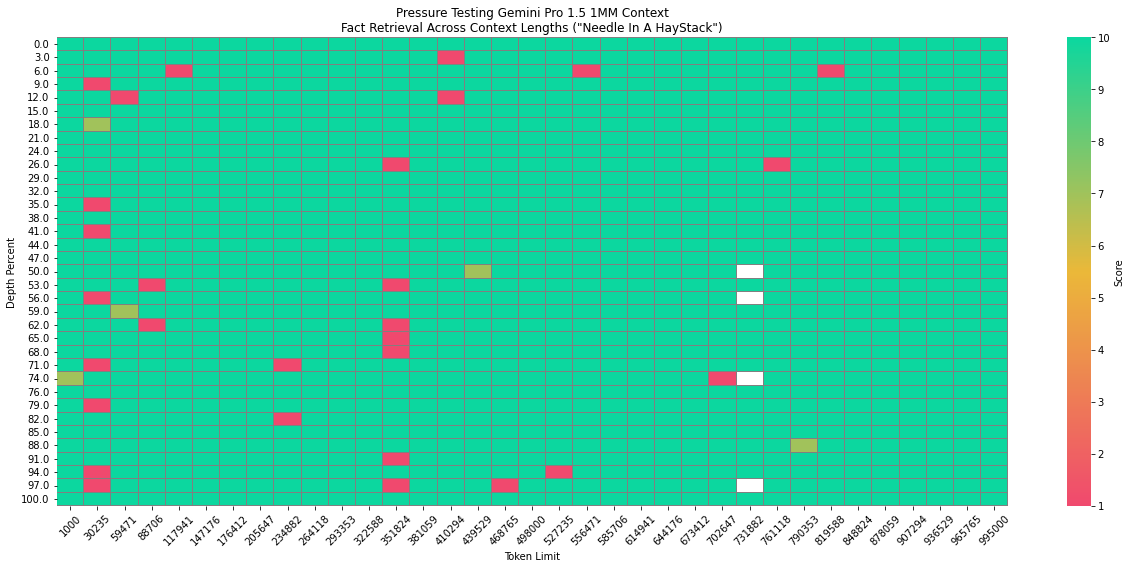

In [16]:
# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# Create the heatmap with better aesthetics
plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
sns.heatmap(
    pivot_table,
    # annot=True,
    fmt="g",
    cmap=cmap,
    cbar_kws={'label': 'Score'}, 
    linewidths=0.01, 
    linecolor='grey'
)

# More aesthetics
plt.title('Pressure Testing Gemini Pro 1.5 1MM Context\nFact Retrieval Across Context Lengths ("Needle In A HayStack")')  # Adds a title
plt.xlabel('Token Limit')  # X-axis label
plt.ylabel('Depth Percent')  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area

# Show the plot
plt.show()

<AxesSubplot:title={'center':'Average Score by Context Length'}, xlabel='Context Length'>

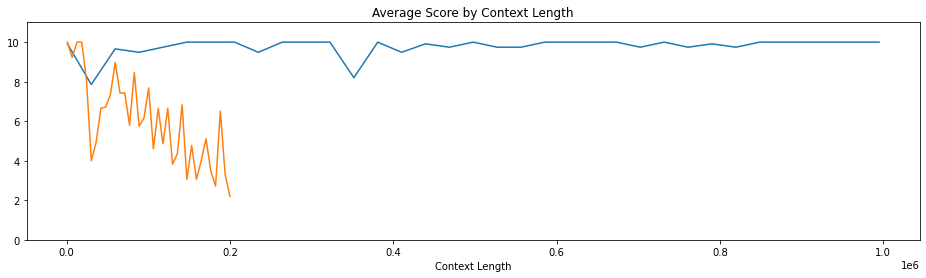

In [19]:
pvt_gmn.mean().plot(figsize=(16,4), title="Average Score by Context Length", ylim=[0,11])
pvt_ant.mean().plot(figsize=(16,4), title="Average Score by Context Length", ylim=[0,11], )